In [ ]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from MaskGenerator.mask_generator.models.my_unet import MyUNet
from mask_generator.transform_manager import TransformManager

In [74]:
MODEL_DIR = '20250530_052145_c65426084f'
model_path_template = '../experiments/{}/model.pth'
model_path = model_path_template.format(MODEL_DIR)

In [75]:
CAR_PICTURE_DIR = "../Datasets/car_pictures/"

pictures = []

for root, dirs, files in os.walk(CAR_PICTURE_DIR):
    for file in files:
        if file.endswith(".png"):
            pictures.append(os.path.join(root, file))

print(len(pictures))

11133


In [76]:
image_path = random.choice(pictures)
print(f"Selected image: {image_path}")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filters = [32, 64, 128, 256]
model = MyUNet(in_channels=3, out_channels=1, filters=filters, n_convs=2).to(device)
# print(f"Using device: {device}")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

original_shape = image.shape
# print(f"Original image shape: {original_shape}")

transform_manager = TransformManager(num_encoders=len(filters), seed=42)
transform = transform_manager.get_eval_transform(to_tensor=True)
transformed = transform(image=image)
applied_transforms = transformed["applied_transforms"]
picture_tensor = transformed["image"]

if not all(x % len(filters) == 0 for x in picture_tensor.shape[1:]):
    print("Image dimensions are not divisible by the number of filters. Resizing...")

with torch.no_grad():
    picture_tensor = picture_tensor.unsqueeze(0).to(device)
    output = model(picture_tensor)
    output = torch.sigmoid(output)
    output = (output > 0.5).float()

Selected image: ../Datasets/car_pictures/256_128/1643_original_image.png_1.png


In [77]:
# print(f"Applied transforms: {applied_transforms}")

print(f"Output shape: {output.shape}")
def get_resized_shape(applied_transforms: list):
    for name, params in applied_transforms:
        if name == "ResizeWithAspectRatio":
            return params.get("resized_shape", None)
    return None

Output shape: torch.Size([1, 1, 256, 512])


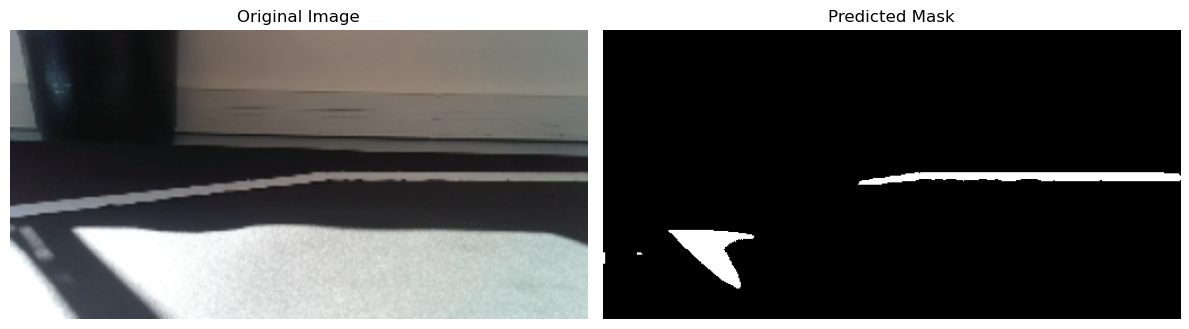

In [78]:
resized_shape = get_resized_shape(applied_transforms)
# print(f"Resized shape: {resized_shape}")

image = TransformManager.reverse_image(picture_tensor, resized_shape)
output_np = TransformManager.reverse_mask(output, resized_shape)

# print(f"Image shape after reverse: {image.shape}")
# print(f"Output mask shape after reverse: {output_np.shape}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(output_np, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()